# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Energy Consumption vs Temperature vs Population (Malta-based)

Model Outcomes:
* Energy Demand Forecasting

# Data Preparation

## Dataset provenance
Electricity:
- [NSO Table 1. Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 2. Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 3. Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 4. Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 5. Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 6. Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 8. GHG emissions from fuel combustion in power plants by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Eurostat Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Population Worldbank](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [NSO Index of Industrial Production November 2018](https://nso.gov.mt/wp-content/uploads/News2019_003.pdf)
- [NSO Index of Industrial Production December 2018](https://nso.gov.mt/wp-content/uploads/News2019_019.pdf)
- [NSO Index of Industrial Production May 2020](https://nso.gov.mt/wp-content/uploads/News2020_109.pdf)
- [NSO Index of Industrial Production December 2020](https://nso.gov.mt/wp-content/uploads/News2021_020.pdf)
- [NSO Short Term Industrial Indicators Q4 2018](https://nso.gov.mt/wp-content/uploads/News2019_033.pdf)

## Preparation

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Linear **interpolation of NaNs**.

In [37]:
import os
import pandas as pd

edf = None

# All unprocessed CVs should go here. 
RAW_DATA_PATH = './raw_data'

ELECTRIC_DS = ['Max_Demand_MW.csv','Supply_MWh.csv','GrossProduction_MWh.csv',\
               'Plant_Production_MWh.csv','Imports_MWh.csv','Exports_MWh.csv', \
               'Renewables_Production_MWh.csv']

for filename in ELECTRIC_DS:
  file_path = os.path.join(RAW_DATA_PATH, filename)
  value_col = filename.split(".")[0]
  print(filename)

  df = pd.read_csv(file_path)

  # Melt this 3 col daily_temp_tsdf in 2 col timeseries
  melted_df = df.melt(id_vars=['Month'], var_name='Year', value_name=value_col)
  melted_df[value_col] = melted_df[value_col].apply(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)

  melted_df['Date'] = pd.to_datetime(melted_df['Month'] + ' ' + melted_df['Year'], format='%B %Y', utc=True)
  melted_df.dropna(inplace=True)
  melted_df.set_index('Date', inplace=True, drop=True)
  result_df = melted_df[[value_col]]

  if edf is None:
      edf = result_df
  else:
      edf = pd.concat([edf, result_df], axis=1, ignore_index=False)

data_temp_tsdf_df = edf
edf.tail(3)

Max_Demand_MW.csv
Supply_MWh.csv
GrossProduction_MWh.csv
Plant_Production_MWh.csv
Imports_MWh.csv
Exports_MWh.csv
Renewables_Production_MWh.csv


,Max_Demand_MW,Supply_MWh,GrossProduction_MWh,Plant_Production_MWh,Imports_MWh,Exports_MWh,Renewables_Production_MWh
Date,,,,,,,
2022-10-01 00:00:00+00:00,411,225886.0,164124.0,140278.0,66130.0,121.0,23846.0
2022-11-01 00:00:00+00:00,411,206396.0,199398.0,182610.0,13054.0,1497.0,16788.0
2022-12-01 00:00:00+00:00,404,207776.0,193126.0,177287.0,22018.0,2630.0,15839.0


With the daily_temp_tsdf cleaned and structured in a simple DF, we can get stats and visualize it.

In [38]:
POP_DS = "malta_population.csv"

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T
pop_df.columns = ["Population"]
pop_df = pop_df[pop_df.index >= '2018']

pop_df.index= pd.to_datetime(pop_df.index, format='%Y', utc=True)
pop_df = pop_df.resample('M')
pop_df = pop_df.bfill().fillna(method = 'ffill')

all_data_df = pd.concat([data_temp_tsdf_df, pop_df], axis=1, ignore_index=False)
pop_df.tail(3)

,Population
2021-11-30 00:00:00+00:00,523417.0
2021-12-31 00:00:00+00:00,523417.0
2022-01-31 00:00:00+00:00,523417.0


In [39]:
TEMP_DS = "temperature.csv"

temp_df = pd.read_csv(f"{RAW_DATA_PATH}/{TEMP_DS}")
temp_df.rename(columns={"Category": "Date", "Annual Mean": "Temperature"}, inplace=True)
temp_df.drop(columns=["5-yr smooth"], inplace=True)

temp_df = temp_df[temp_df['Date'] >= 2018]
temp_df['Date'] = pd.to_datetime(temp_df['Date'], format='%Y', utc=True)
temp_df.set_index("Date", inplace=True, drop=True)

temp_df = temp_df.resample('M').bfill().fillna(method = 'ffill')

all_data_df = pd.concat([all_data_df, temp_df], axis=1, ignore_index=False)
temp_df.tail(3)

,Temperature
Date,
2021-11-30 00:00:00+00:00,20.26
2021-12-31 00:00:00+00:00,20.26
2022-01-31 00:00:00+00:00,20.26


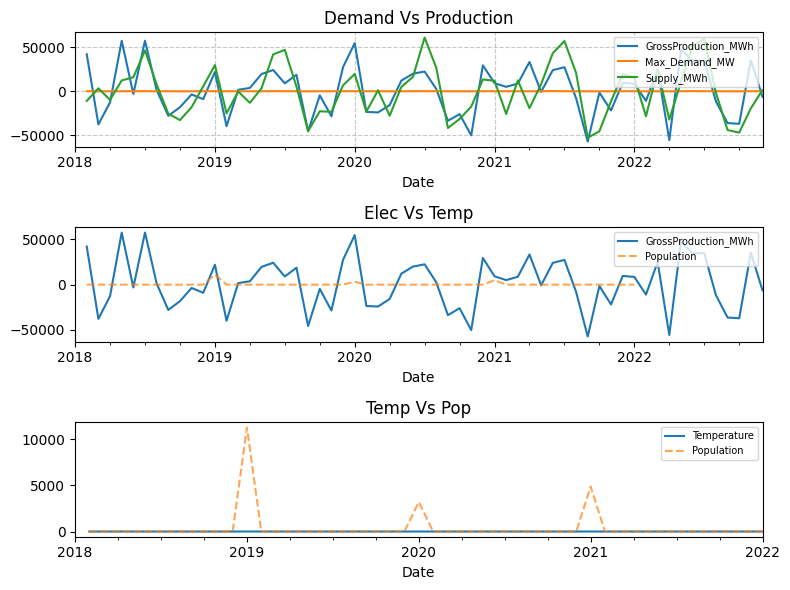

In [40]:
import matplotlib.pyplot as plt


prod_cols = ['GrossProduction_MWh', 'Max_Demand_MW', 'Supply_MWh']
import_export_cols = ['Imports_MWh', 'Exports_MWh']
renew_cols = ['Renewables_Production_MWh','Supply_MWh' ]

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

edf[prod_cols].diff().plot(kind='line', ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].grid(axis='both', linestyle='--', alpha=0.7)
axes[0].set_title('Demand Vs Production')
axes[0].legend(fontsize=7, loc='upper right')

edf['GrossProduction_MWh'].diff().plot(kind='line', ax=axes[1])
pop_df.diff().plot(kind='line', ax=axes[1], linestyle='--', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_title('Elec Vs Temp')
axes[1].legend(fontsize=7, loc='upper right')

temp_df.diff().plot(kind='line', ax=axes[2])
pop_df.diff().plot(kind='line', ax=axes[2], linestyle='--', alpha=0.7)
axes[2].set_xlabel('Date')
axes[2].set_title('Temp Vs Pop')
axes[2].legend(fontsize=7, loc='upper right')

plt.tight_layout()
plt.show()

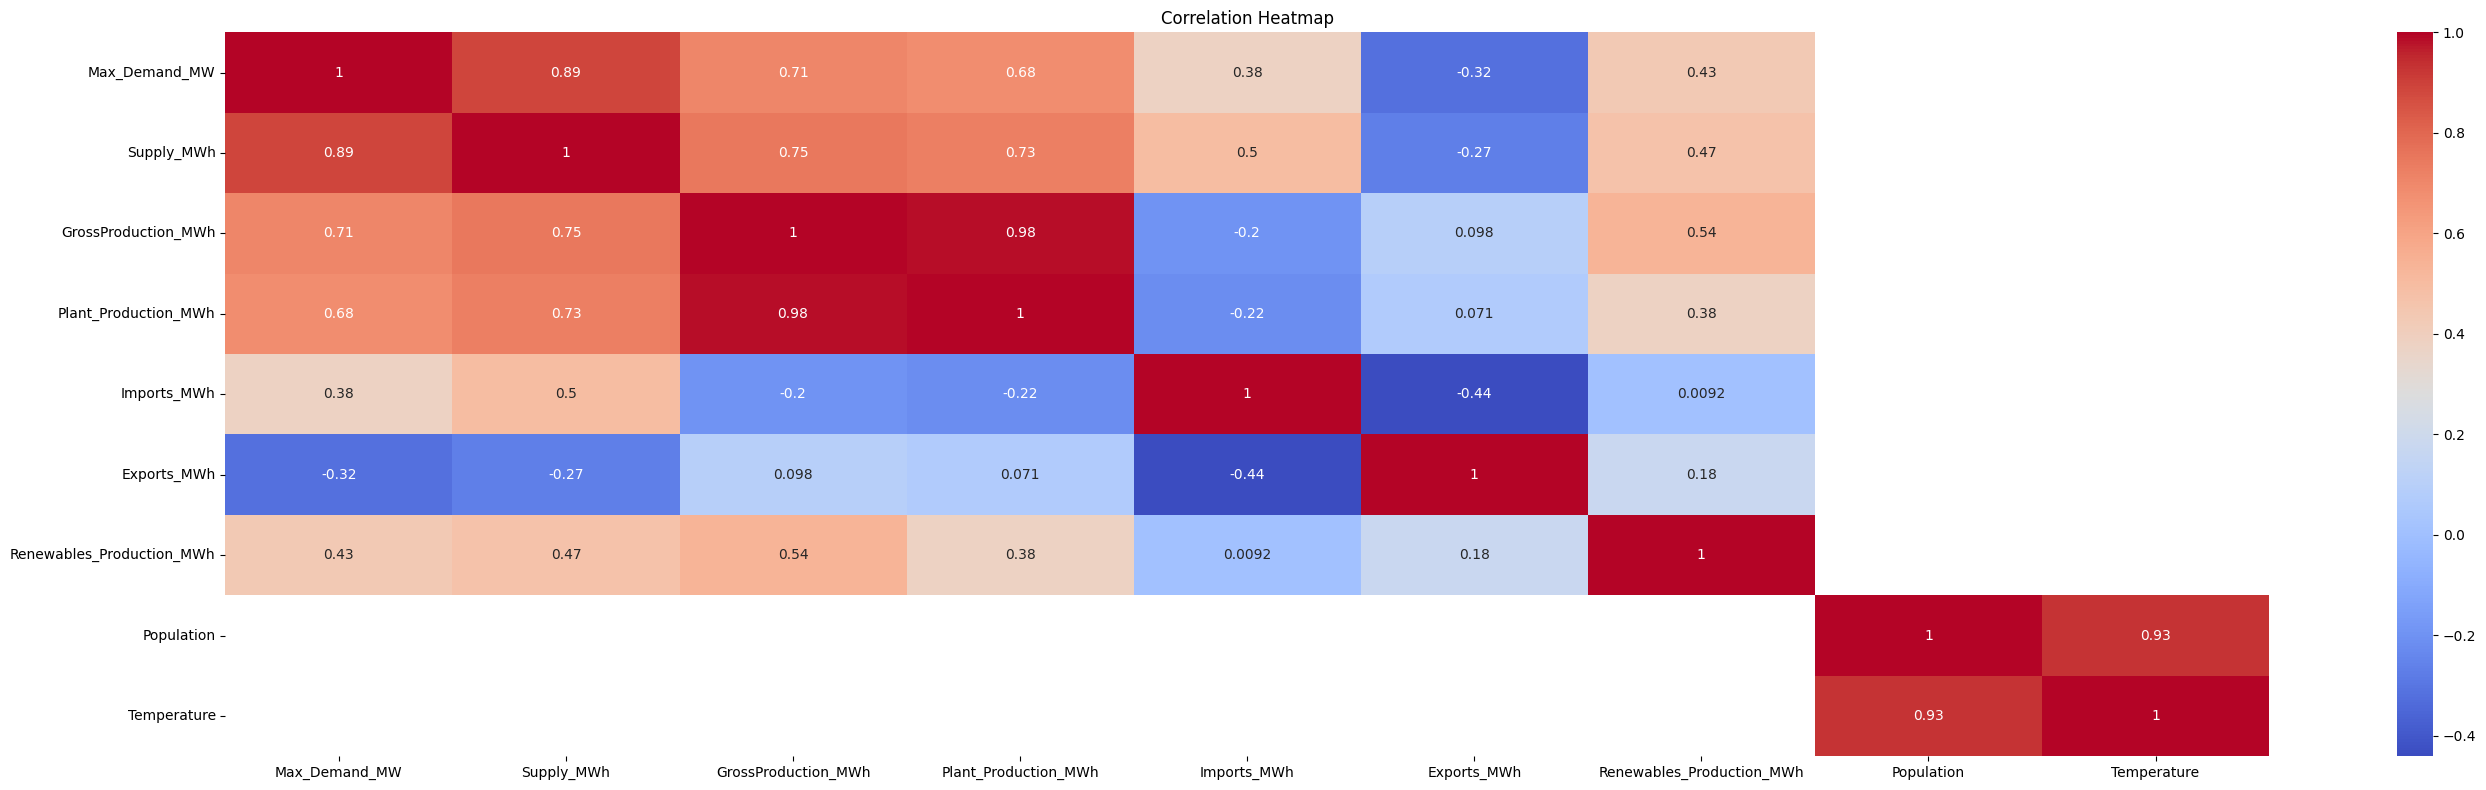

In [41]:
import seaborn as sns

plt.figure(figsize=(28, 8))

corr_matrix = all_data_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [42]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily


start = datetime(2018, 1, 1)
end = datetime(2023, 10, 31)

# Create Point for Malta - specify latitude and longitude
malta = Point(35.8992, 14.5141)
daily_temp_data = Daily(malta, start, end)
daily_temp_data = daily_temp_data.fetch()

daily_temp_data.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,2129.000000,2115.000000,2127.000000,1864.000000,0.0,2027.000000,2051.000000,0.0,2091.000000,0.0
mean,19.711367,16.327943,23.630889,1.039378,NaN,221.510113,15.889566,NaN,1016.222286,NaN
std,5.899683,5.578791,6.626042,4.902797,NaN,100.848162,7.303033,NaN,5.409089,NaN
min,7.400000,3.700000,9.600000,0.000000,NaN,0.000000,3.900000,NaN,991.300000,NaN
25%,14.600000,11.800000,17.600000,0.000000,NaN,142.000000,10.200000,NaN,1012.800000,NaN
50%,19.100000,16.000000,22.900000,0.000000,NaN,257.000000,14.100000,NaN,1015.700000,NaN
75%,25.200000,21.600000,29.600000,0.000000,NaN,304.500000,20.100000,NaN,1019.350000,NaN
max,34.600000,29.900000,42.700000,108.700000,NaN,359.000000,51.700000,NaN,1033.200000,NaN


In [43]:
daily_temp_data.isna().count()

tavg    2130
tmin    2130
tmax    2130
prcp    2130
snow    2130
wdir    2130
wspd    2130
wpgt    2130
pres    2130
tsun    2130
dtype: int64

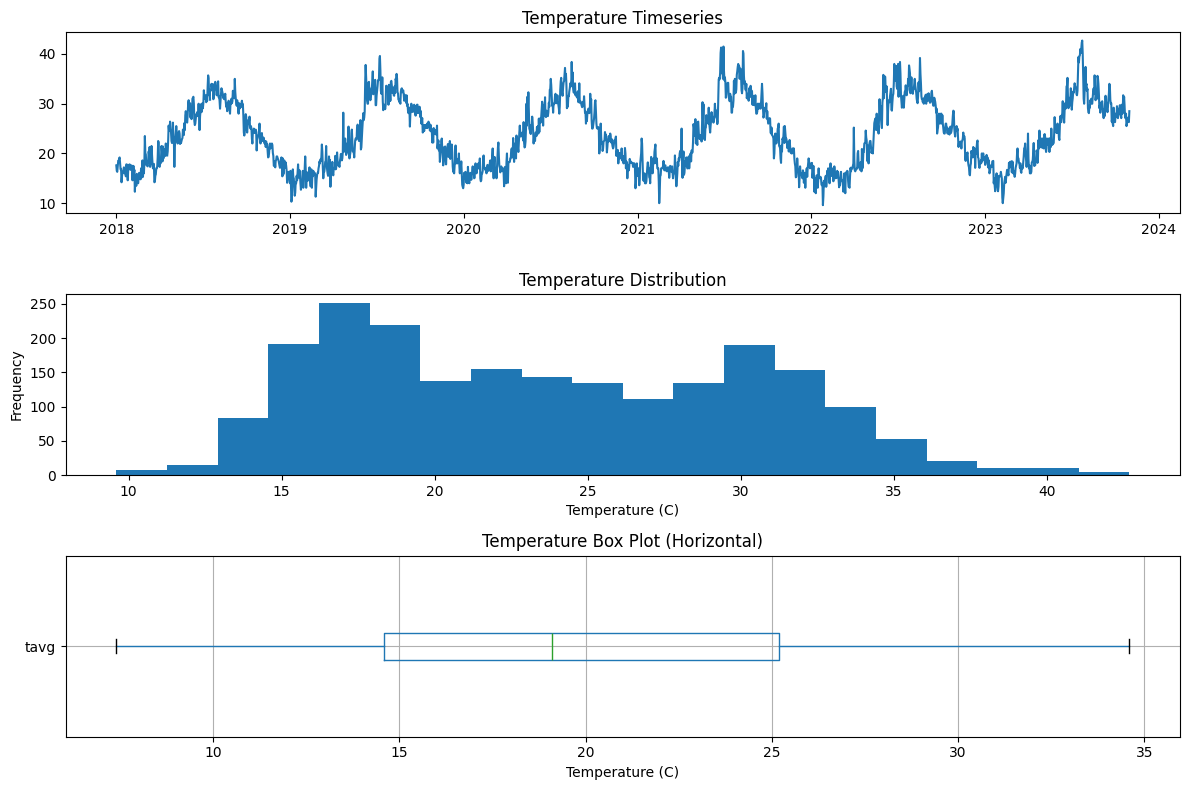

In [44]:
daily_temp_tsdf = daily_temp_data['tmax']

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
axes[0].plot(daily_temp_tsdf)
axes[0].set_title('Temperature Timeseries')

axes[1].hist(daily_temp_tsdf, bins=20)
axes[1].set_xlabel('Temperature (C)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Temperature Distribution')

daily_temp_data.boxplot(column='tavg', vert=False)
axes[2].set_title('Temperature Box Plot (Horizontal)')
axes[2].set_xlabel('Temperature (C)')

plt.tight_layout()
plt.show()